# Code to find the resolution of the model
We want to find the resolution between the predicted and true vertex

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import uproot
import seaborn as sns

from typing import Tuple, Dict, List
import os

import torch
import torch_geometric
from torch_geometric.loader import DataLoader
from torch_geometric.nn import ResGatedGraphConv, global_mean_pool, global_max_pool, global_add_pool
from torch_geometric.nn.norm import BatchNorm
from torch.nn import Dropout, Linear, Sigmoid, LogSoftmax, ReLU, LeakyReLU, SiLU
import omegaconf
from omegaconf import OmegaConf

sys.path.append('/sps/t2k/cehrhardt/analysis_tools/tools')
from test_GCN.utils import train, Normalize
from dataset_from_processed import DatasetFromProcessed

from Caverns.WatChMaL.watchmal.model.grant_gnn import ResGateConv_v2, ResGateConv_v3, ResGateConv_activation


# Check layers distributions

In [2]:

# Load predictions from prediction.npz
predictions_data = np.load('/sps/t2k/cehrhardt/analysis_tools/distributions/2024-07-29_10-12/prediction.npz', allow_pickle=True)
predictions = predictions_data['trained']
# predictions_first = predictions_data['untrained']

# Load intermediate values from intermediate_values.npz
# intermediate_values_data = np.load('/sps/t2k/cehrhardt/analysis_tools/distributions/2024-07-04_13-49/intermediate_values.npz', allow_pickle=True)
# intermediate_values_trained = intermediate_values_data['distributions'][0] # Add .item() to access the dictionary
# intermediate_values_untrained = intermediate_values_data['distributions'][1] # Add .item() to access the dictionary

# # Print keys of intermediate_values_last
# print("Keys of intermediate_values_last:")
# print(intermediate_values_trained.keys())

# # Print keys of intermediate_values_first
# print("\nKeys of intermediate_values_first:")
# print(intermediate_values_untrained.keys())

In [3]:
# Print shapes of intermediate_values_last
print("Shapes of intermediate_values_last:")
for key, value in intermediate_values_trained.items():
    print(key)
    print(value[:,1])
    break

Shapes of intermediate_values_last:
input
tensor([0.5999, 0.4230, 0.5847,  ..., 0.8437, 0.0912, 0.7443])


## Before modifcation

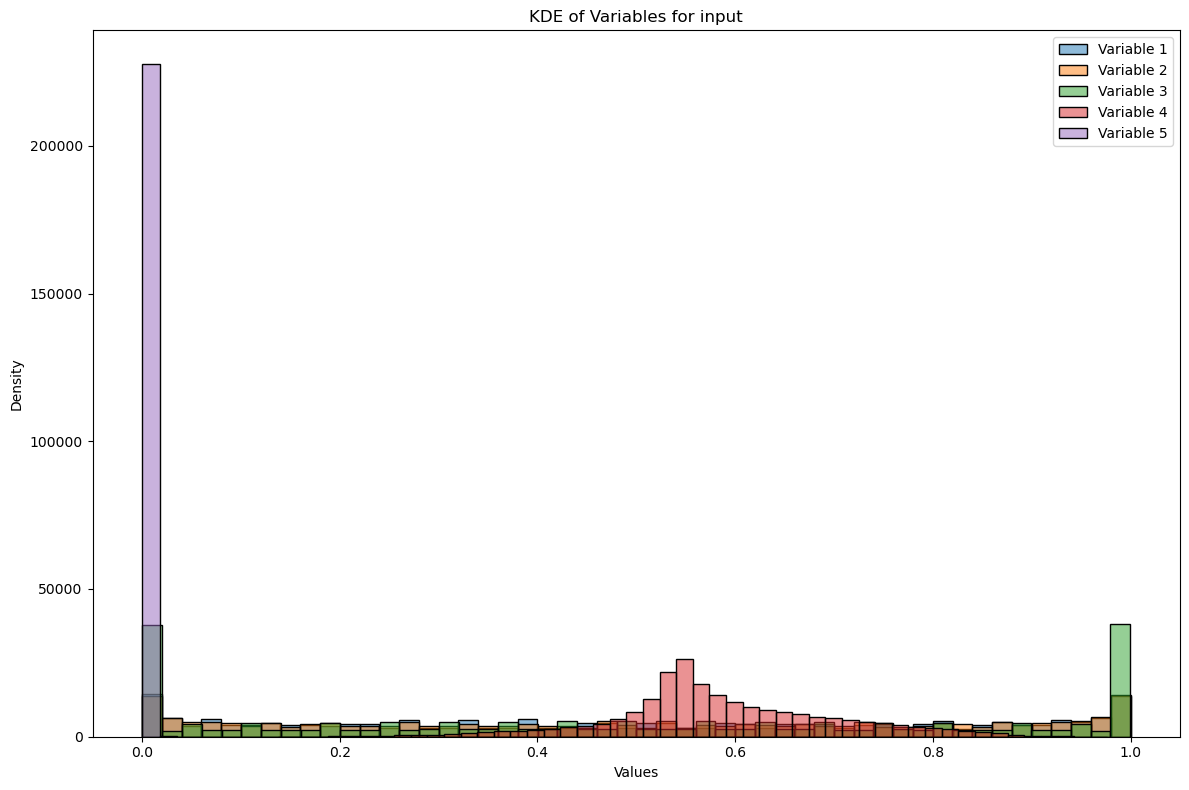

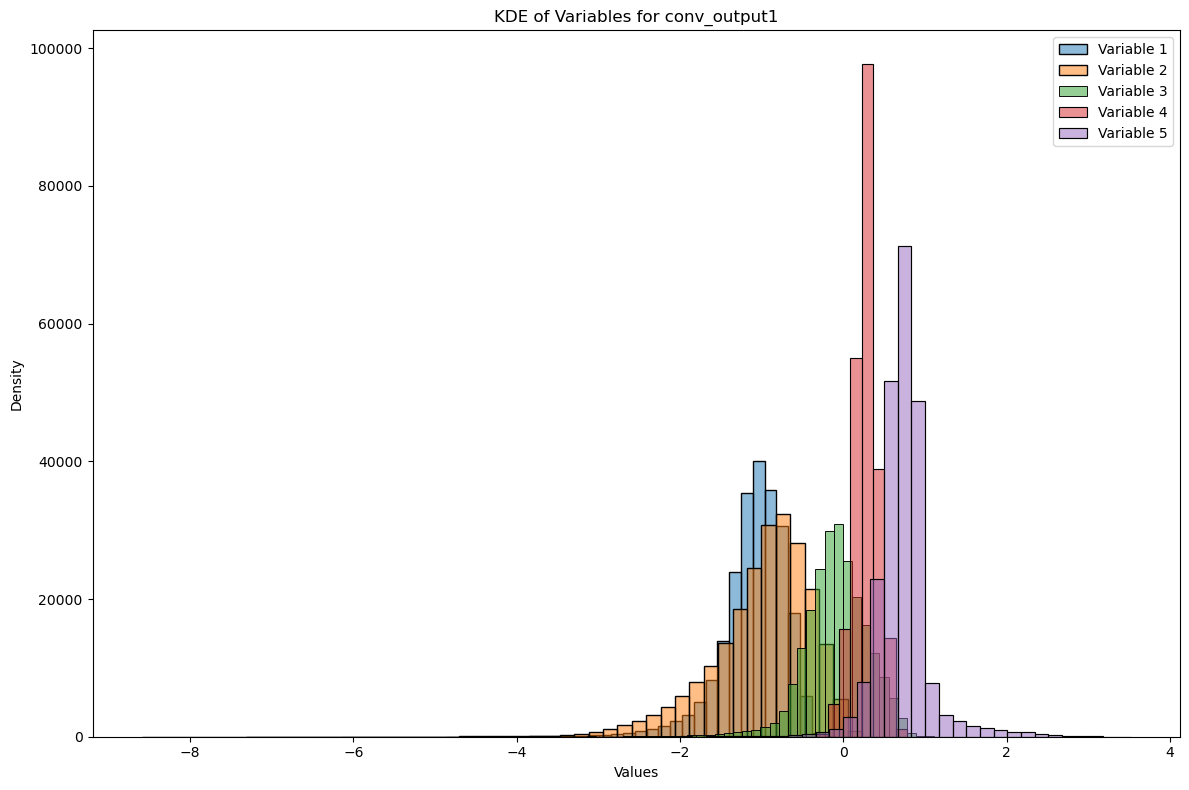

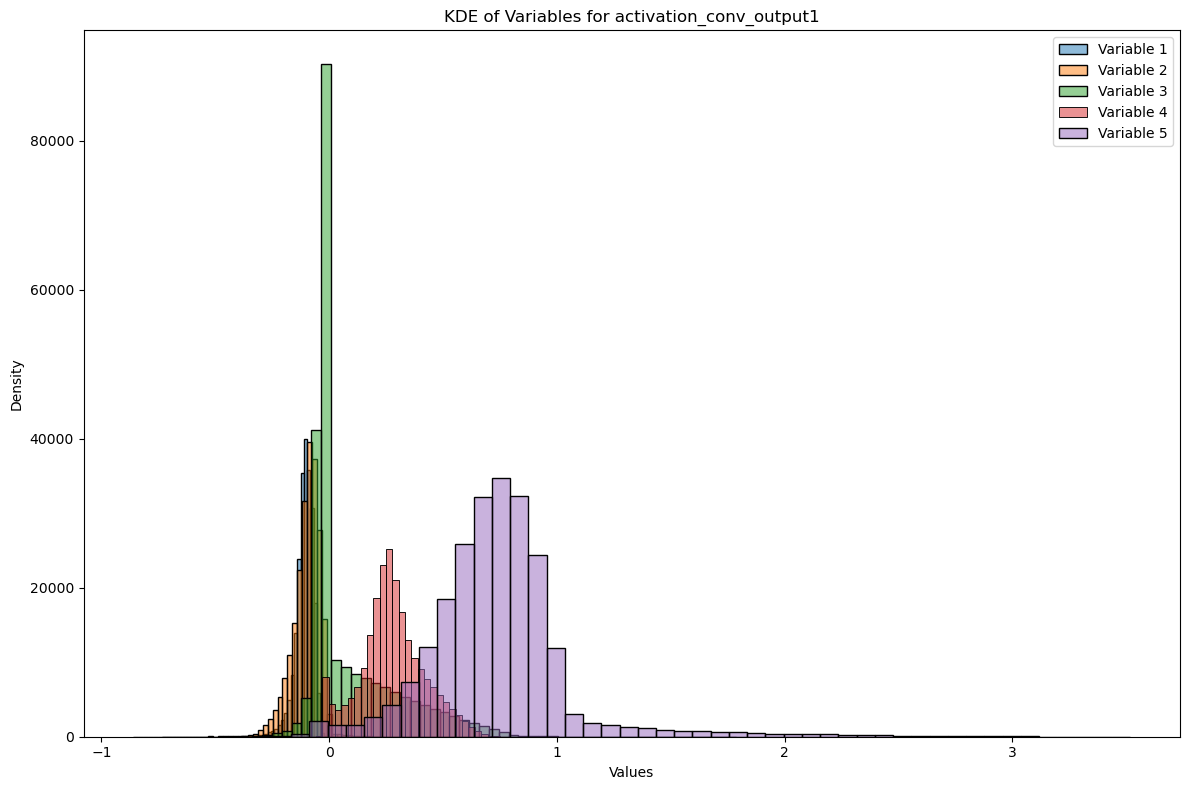

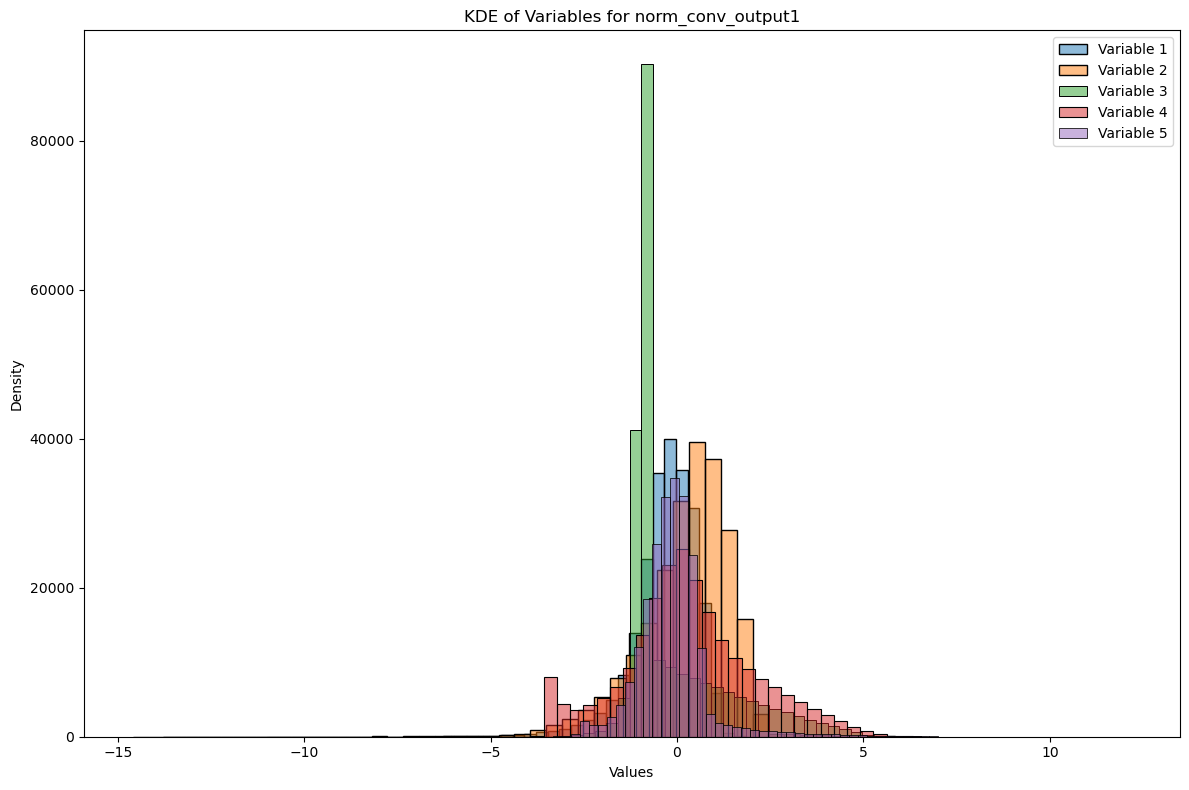

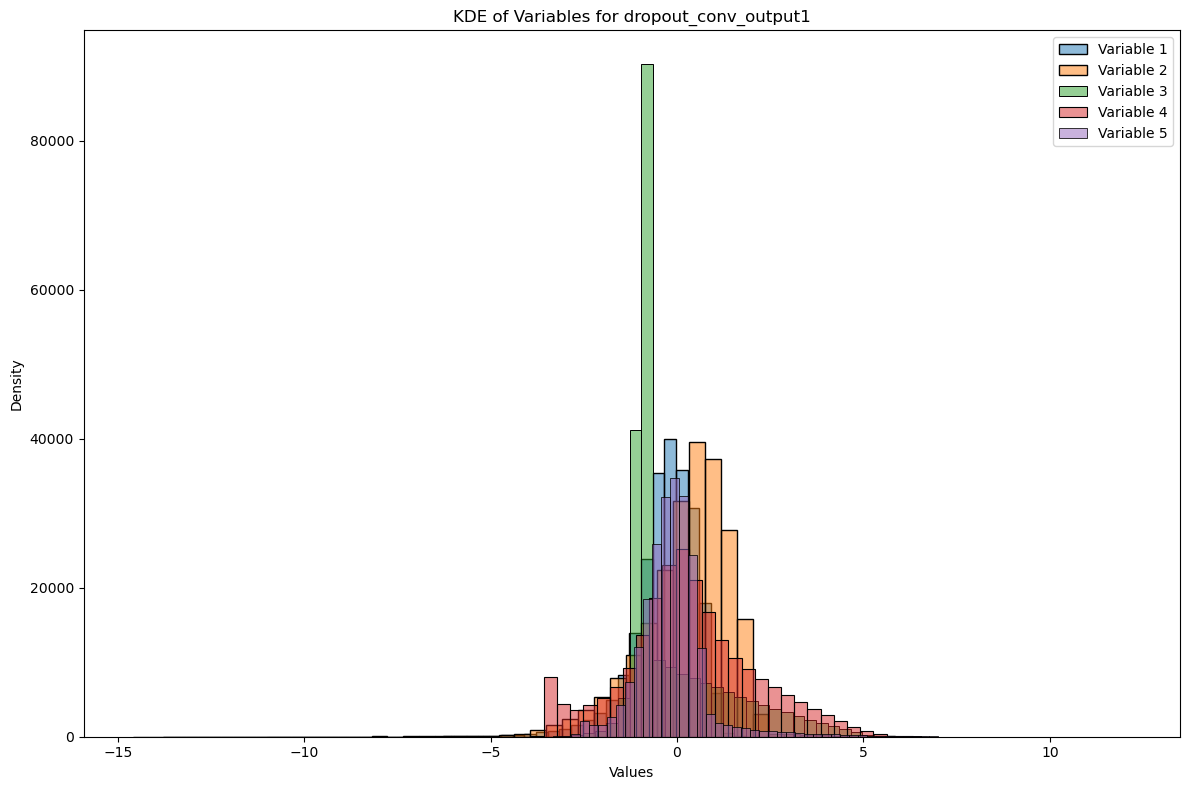

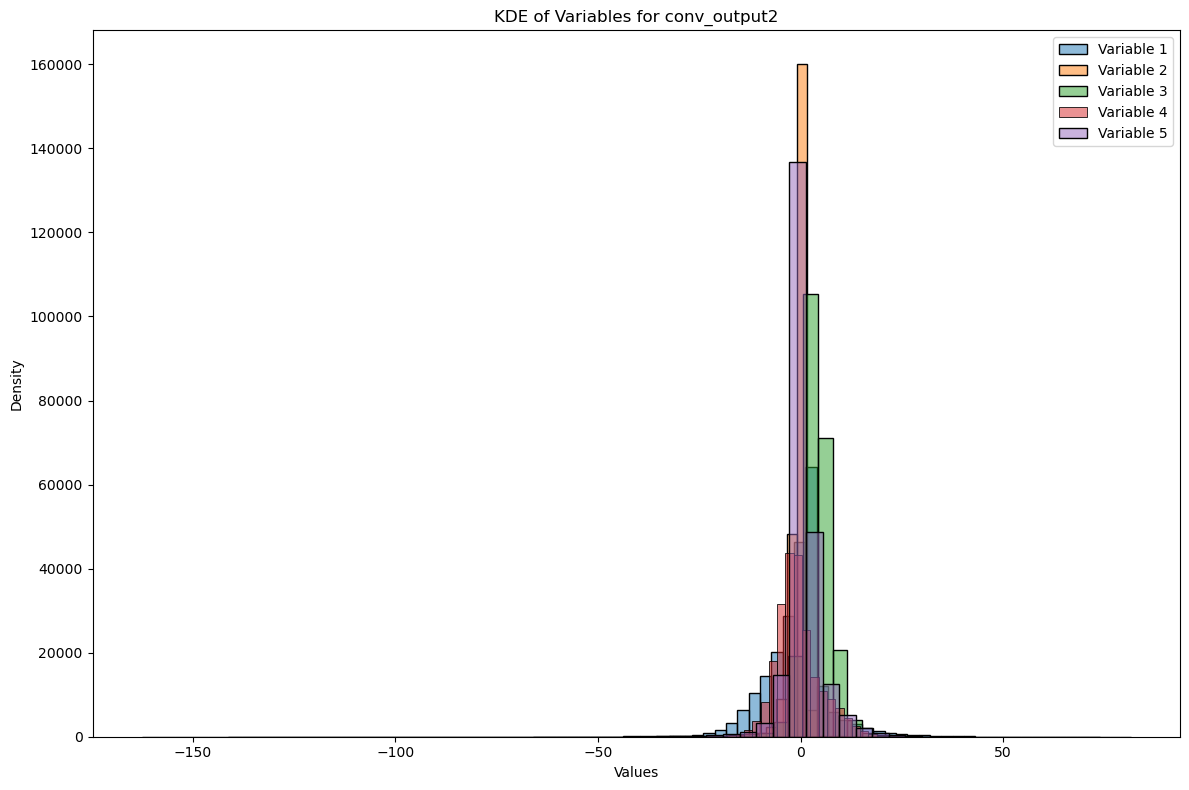

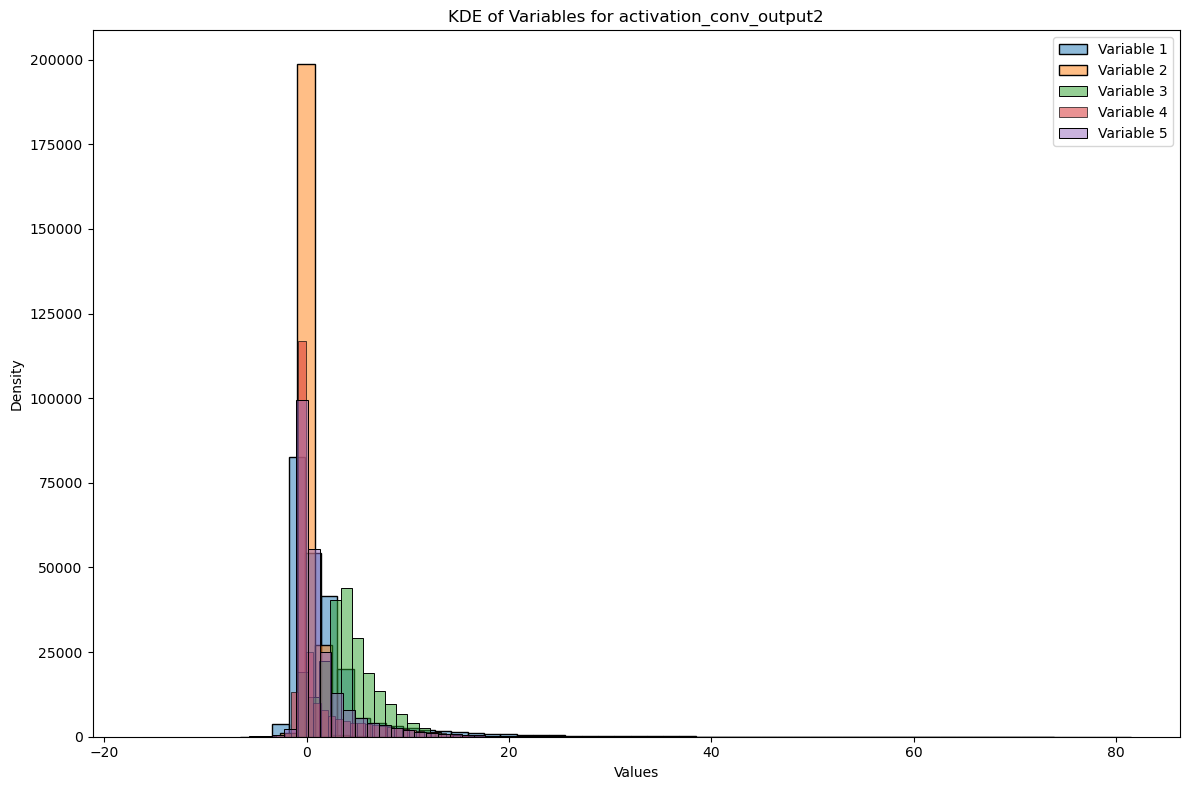

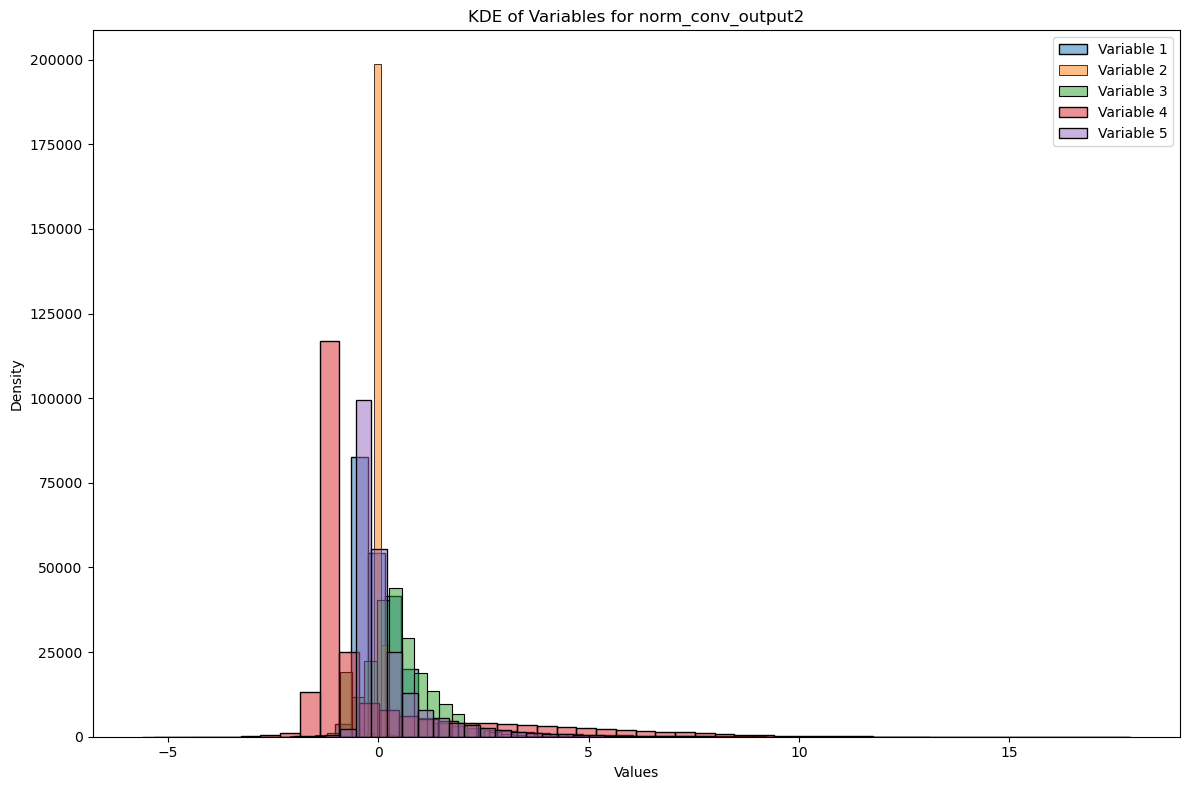

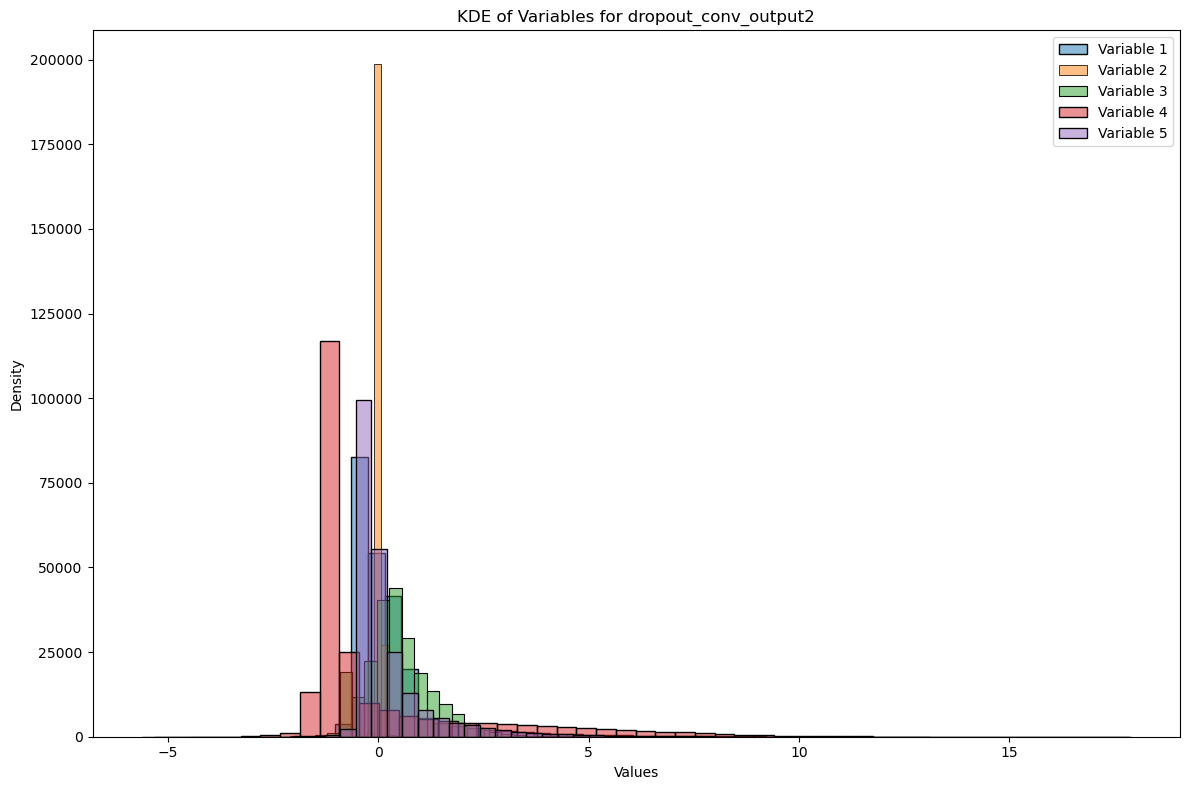

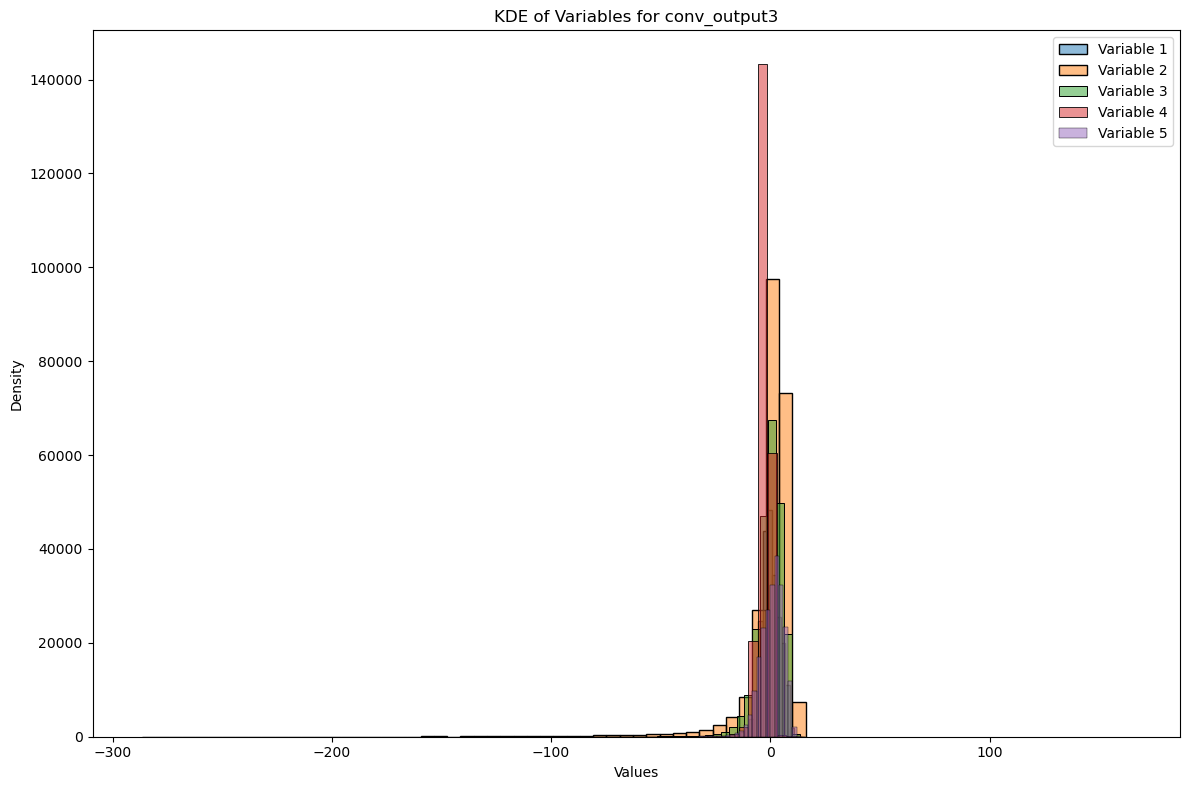

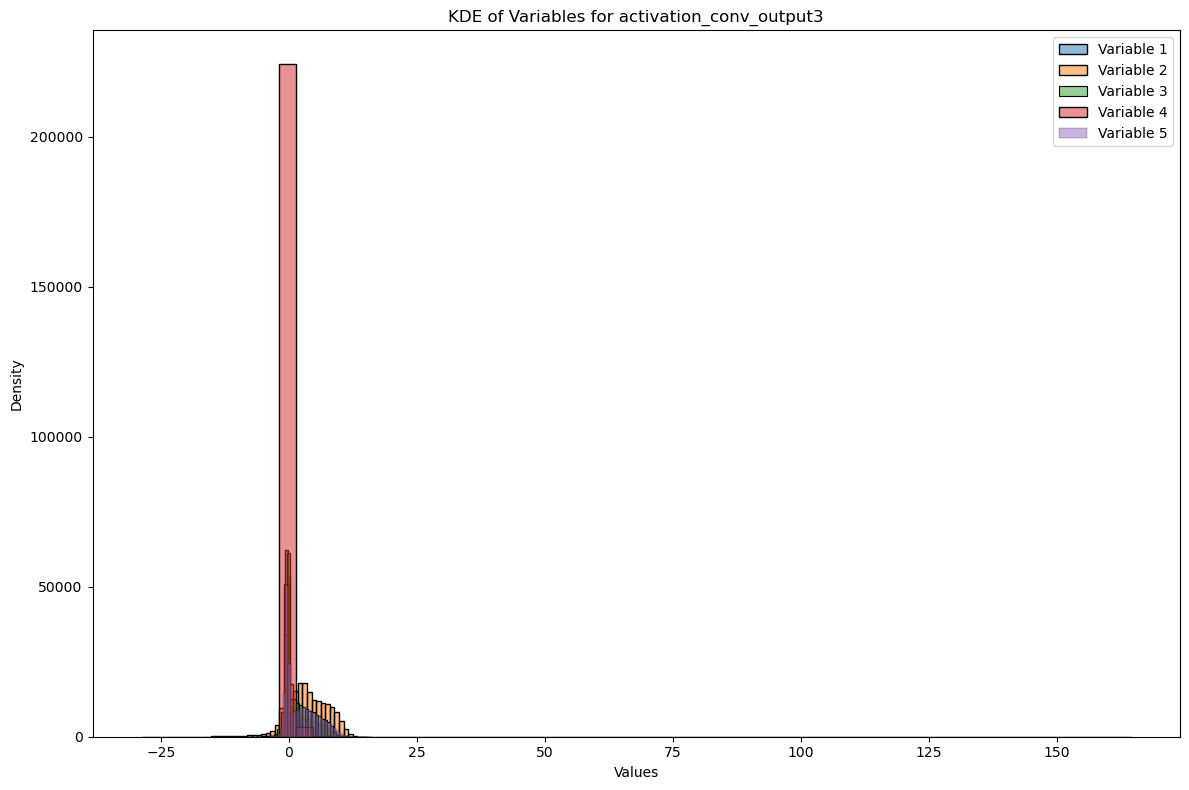

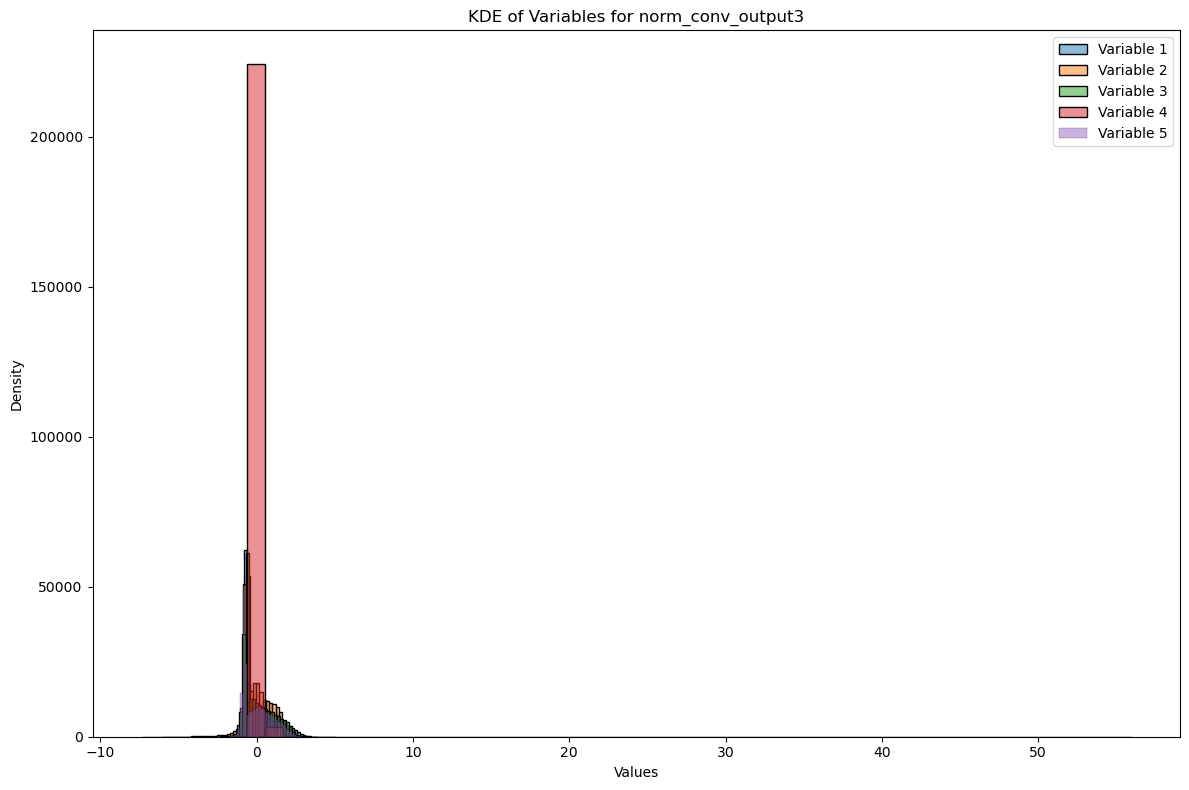

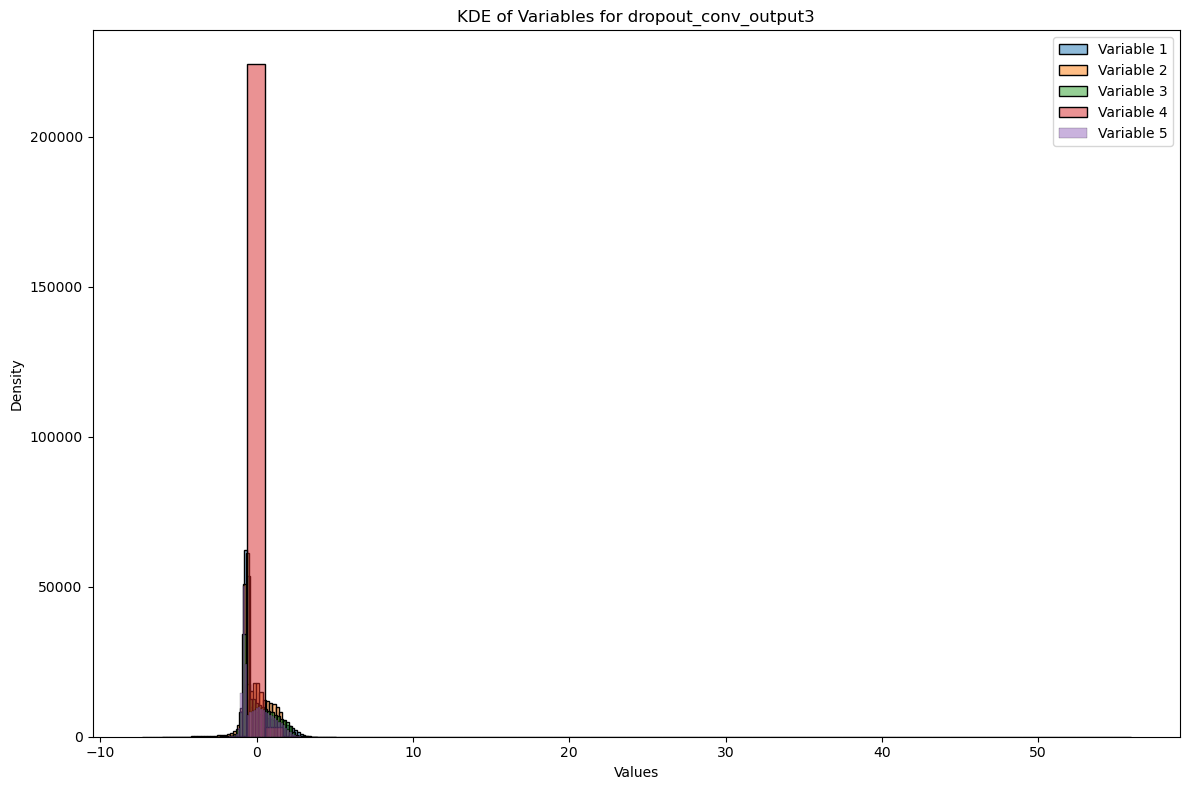

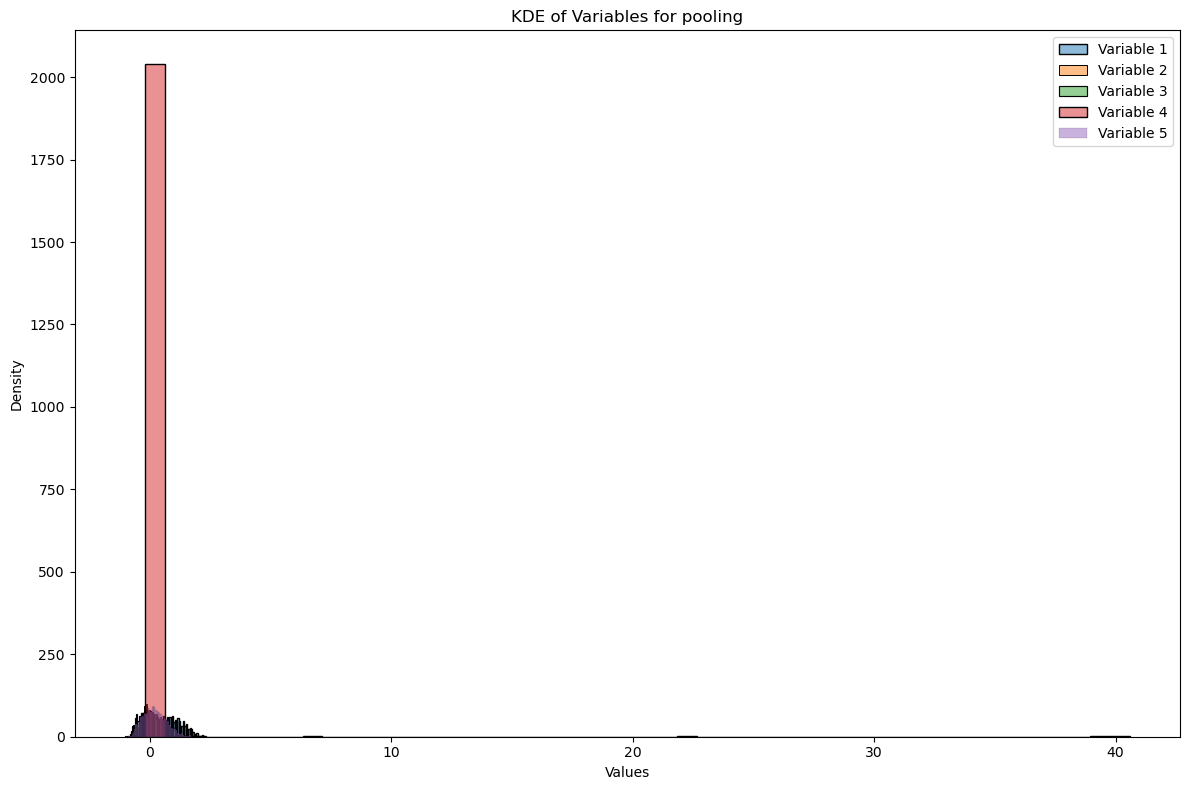

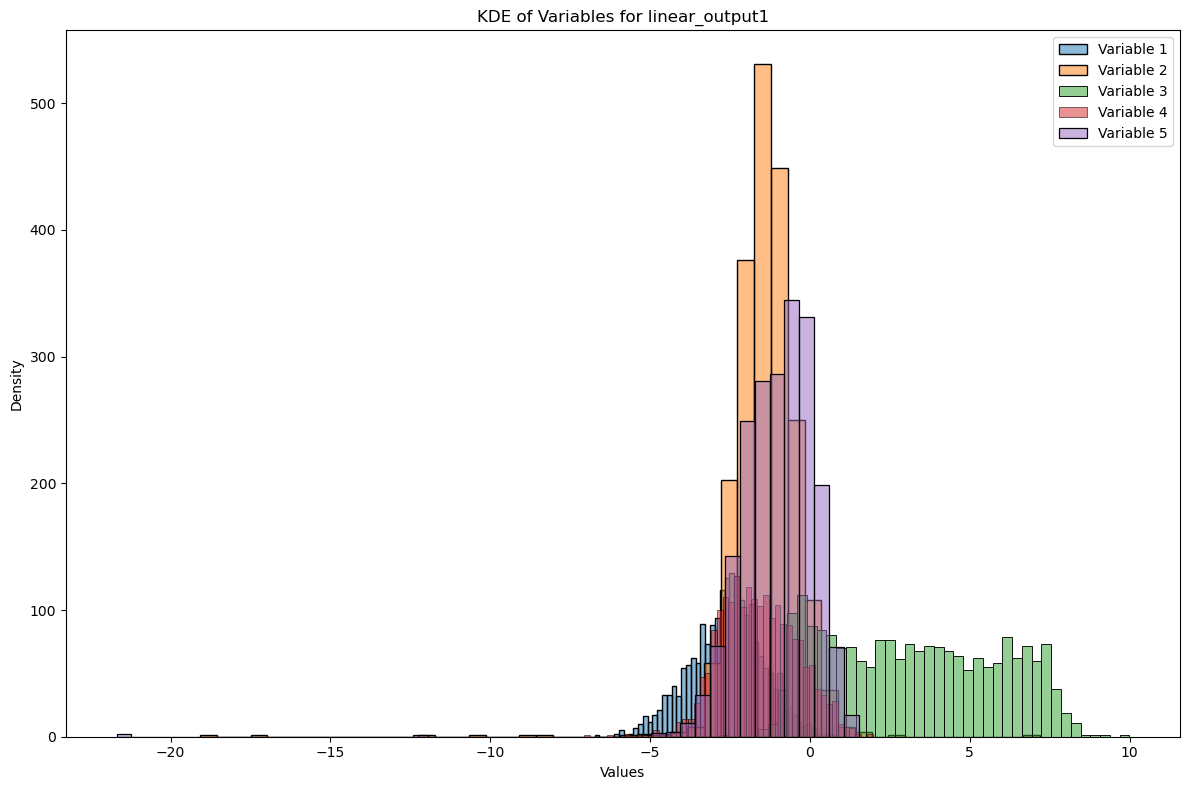

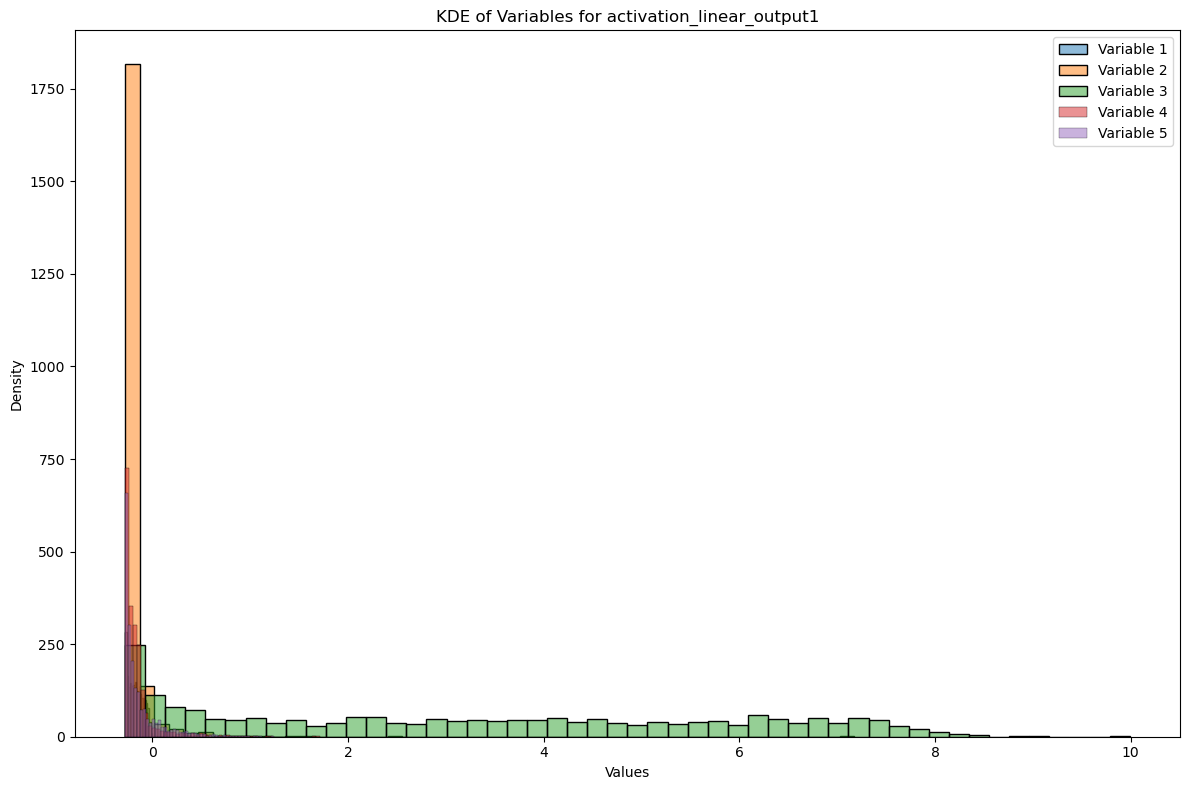

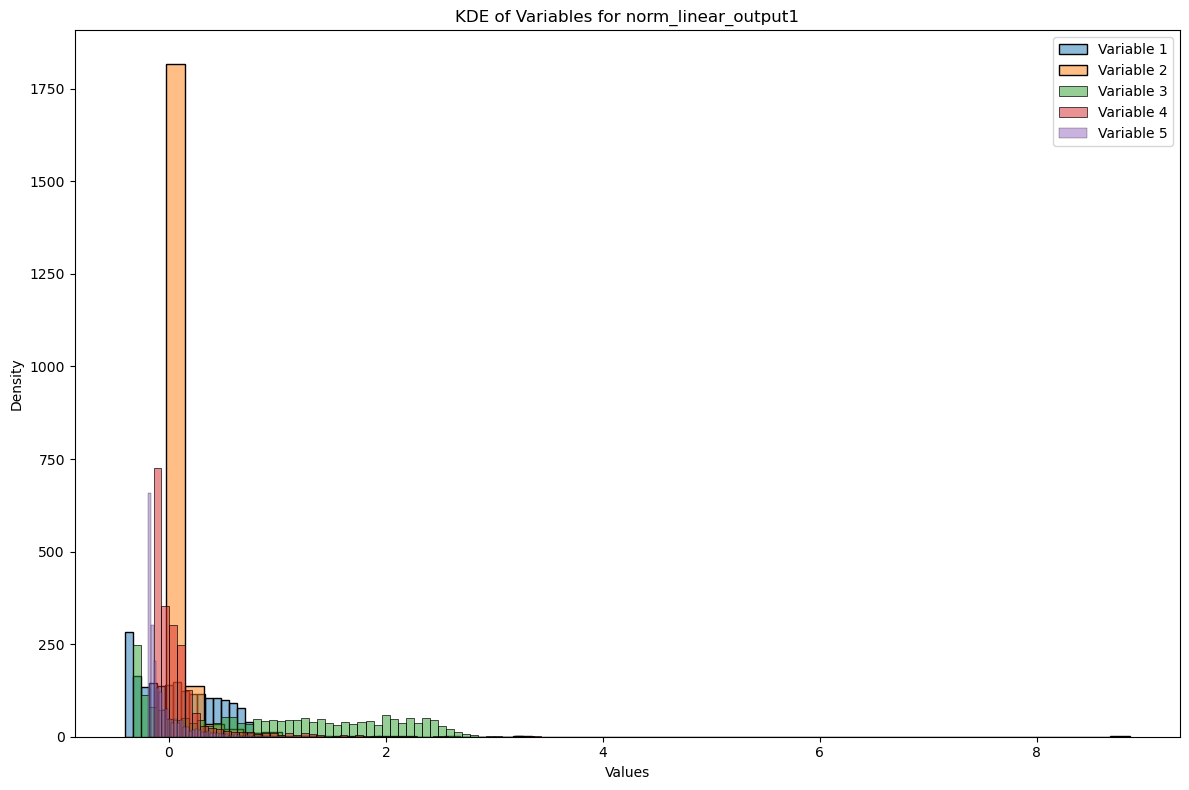

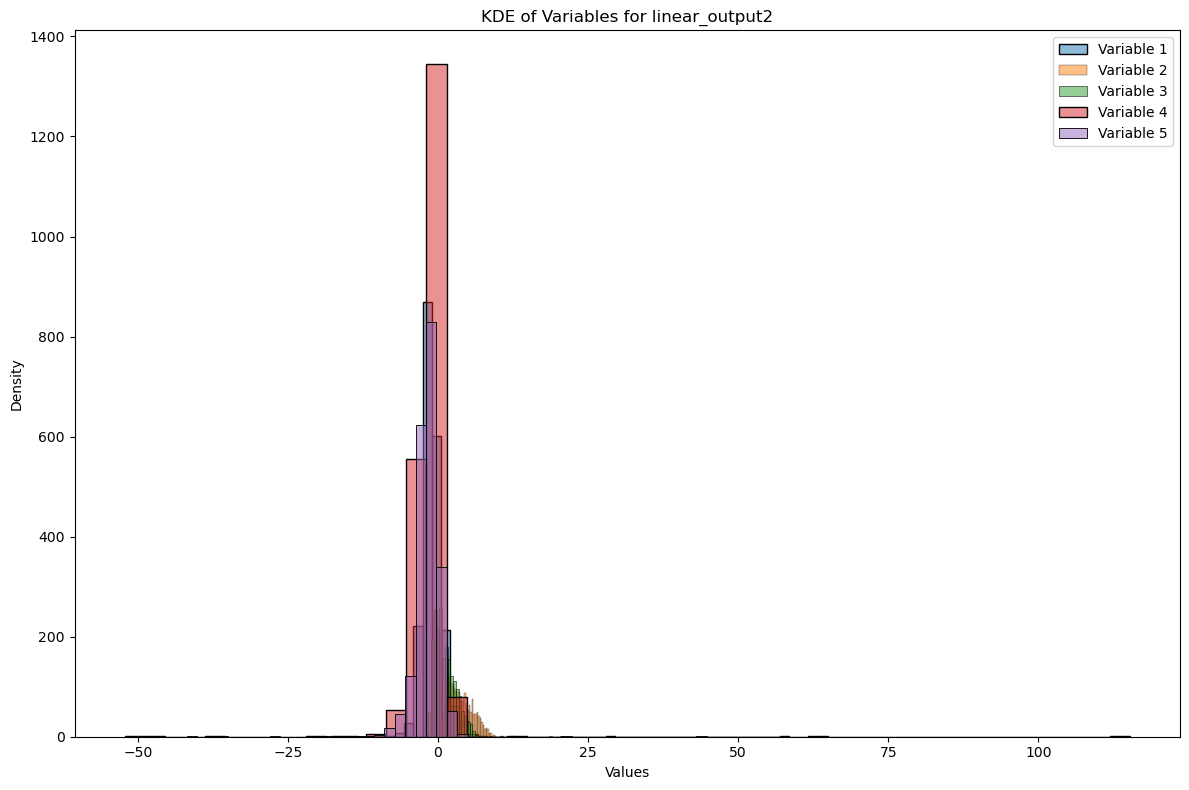

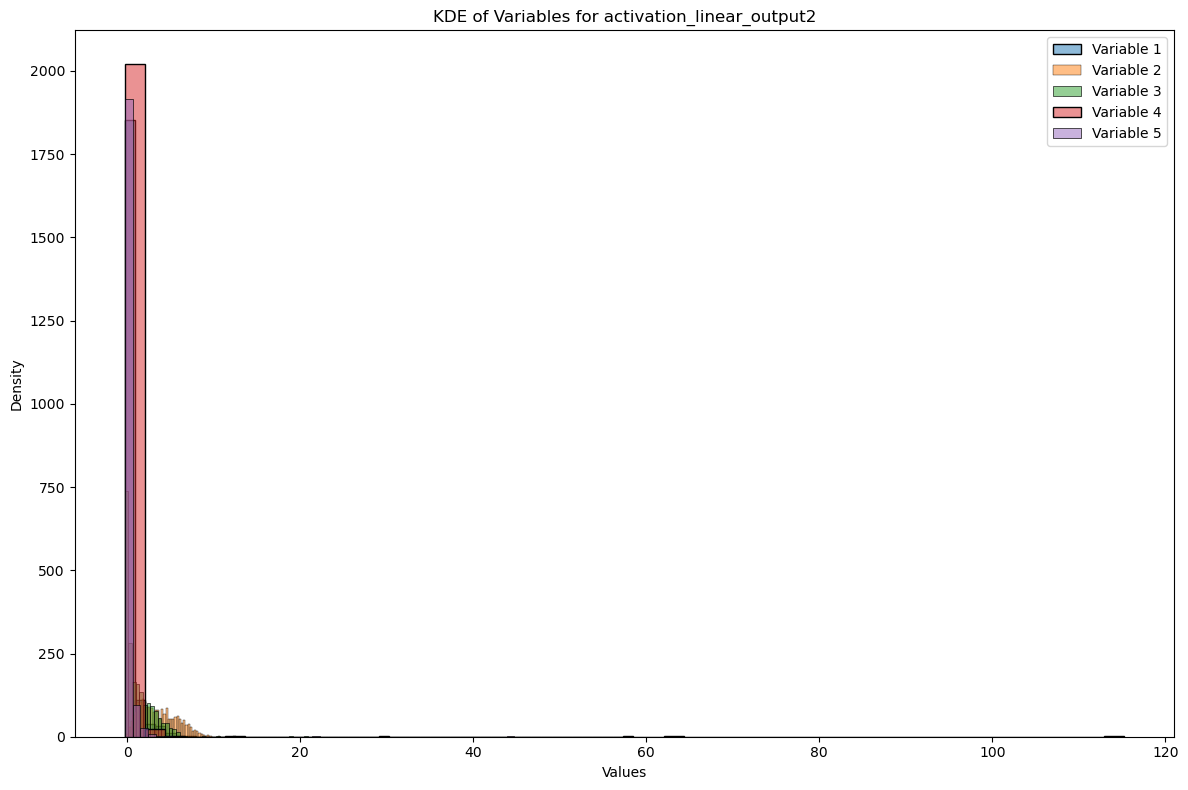

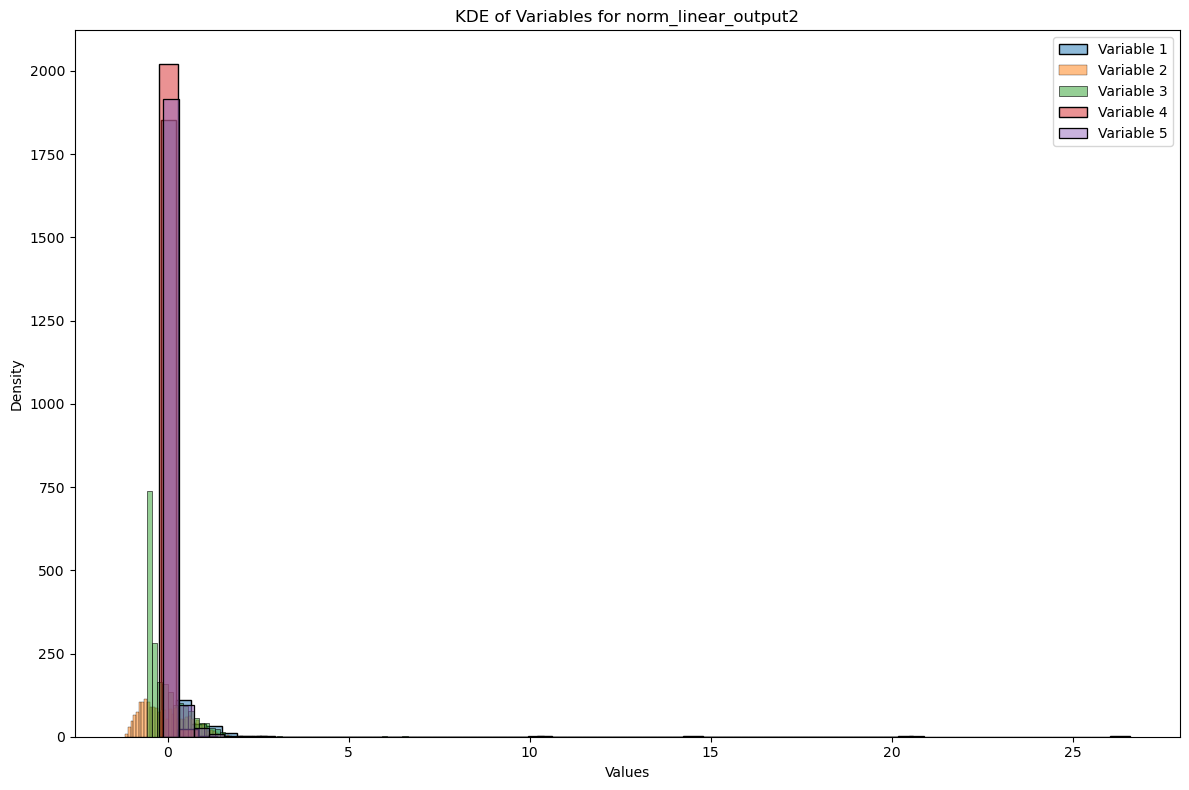

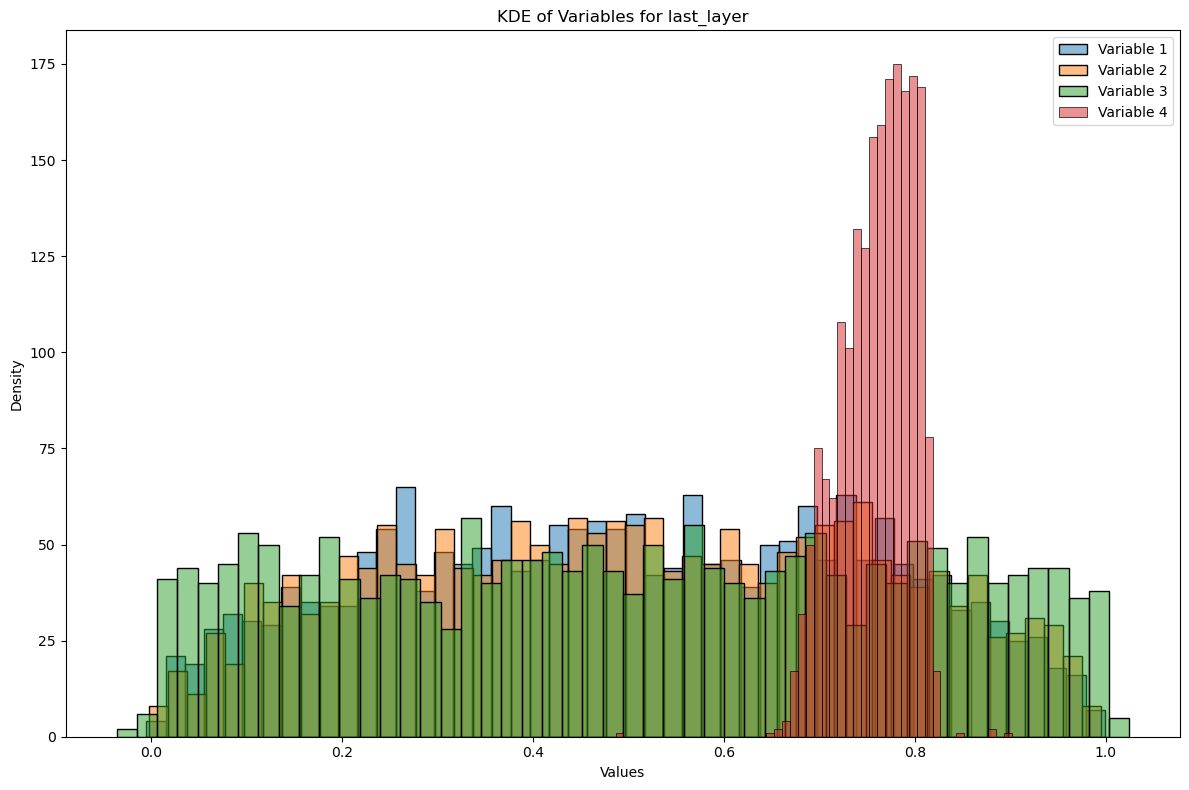

In [5]:
max_vars = 5

# Plot KDE for each key separately
for key, value in intermediate_values_trained.items():
    num_vars = min(value.size(1), max_vars)
    
    plt.figure(figsize=(12, 8))  # Adjust figure size if needed
    
    # Plot KDE for each variable of the current key
    for i in range(num_vars):
        variable_data = value[:, i].cpu().numpy()
        sns.histplot(variable_data, bins=50, kde=False, label=f'Variable {i+1}', alpha=0.5)
    
    plt.title(f'KDE of Variables for {key}')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()


## After modification

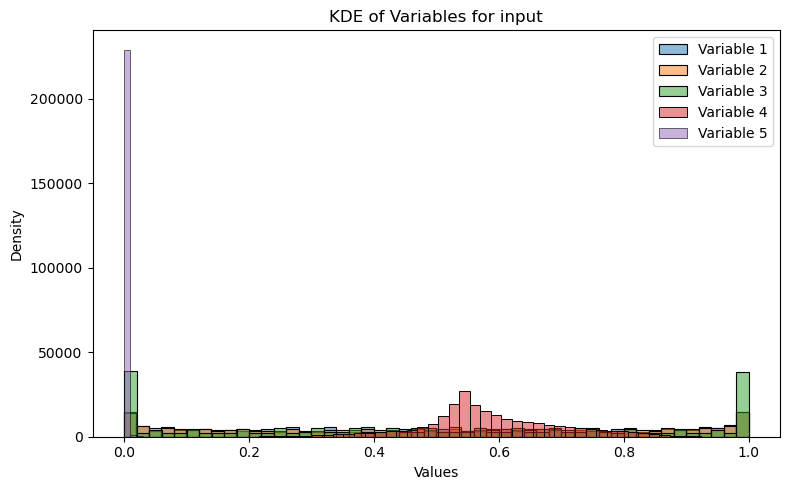

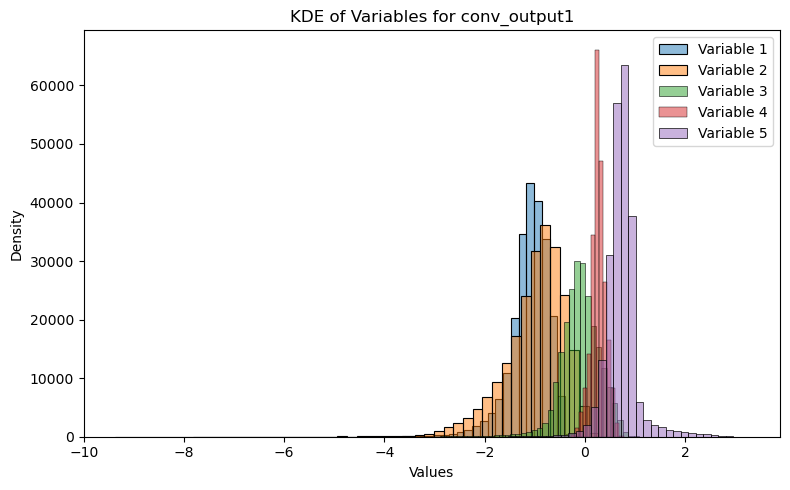

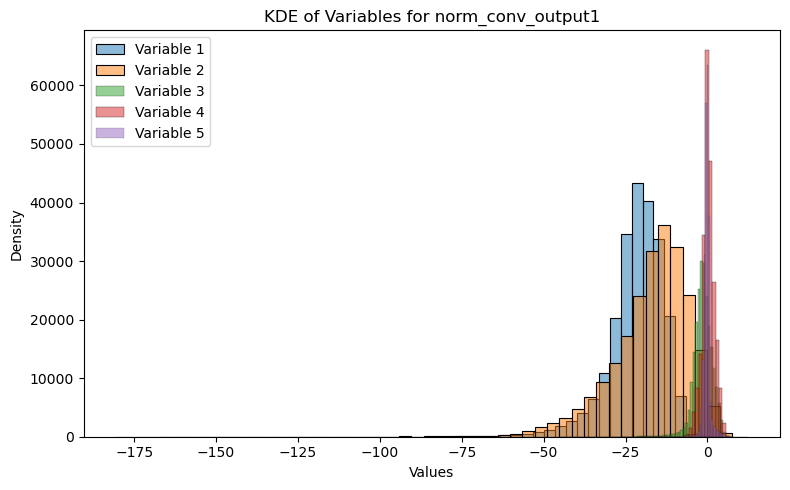

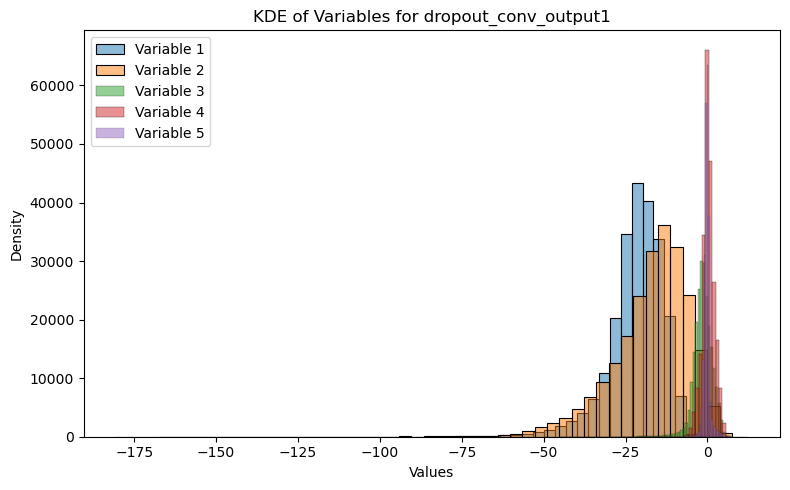

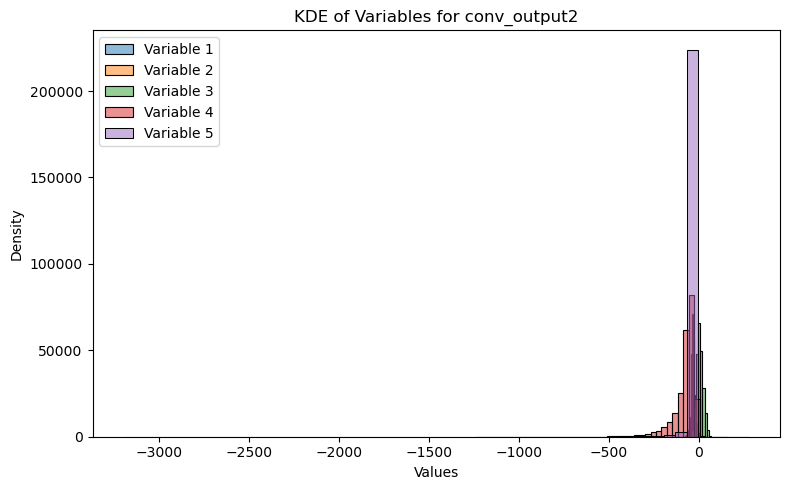

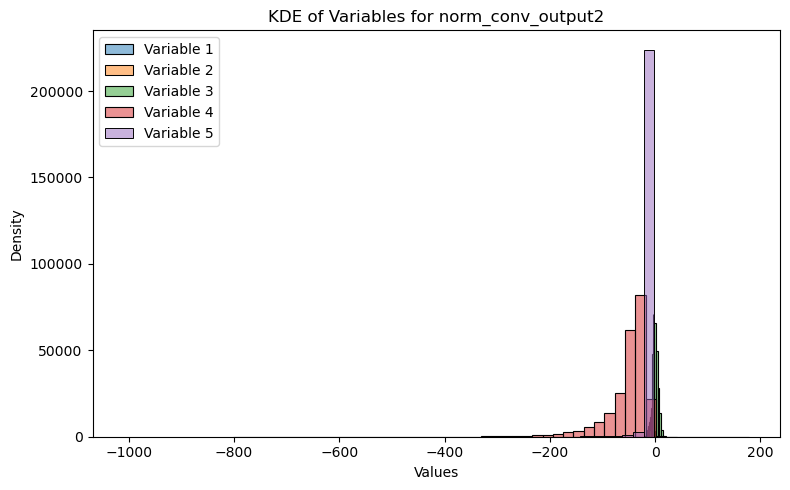

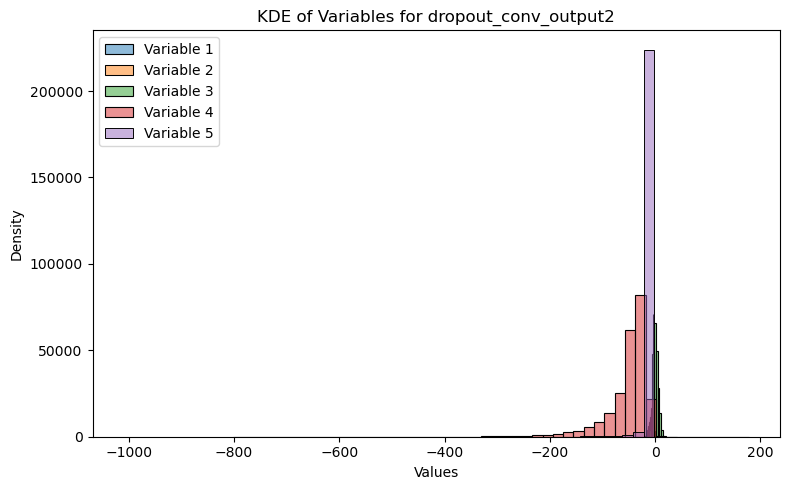

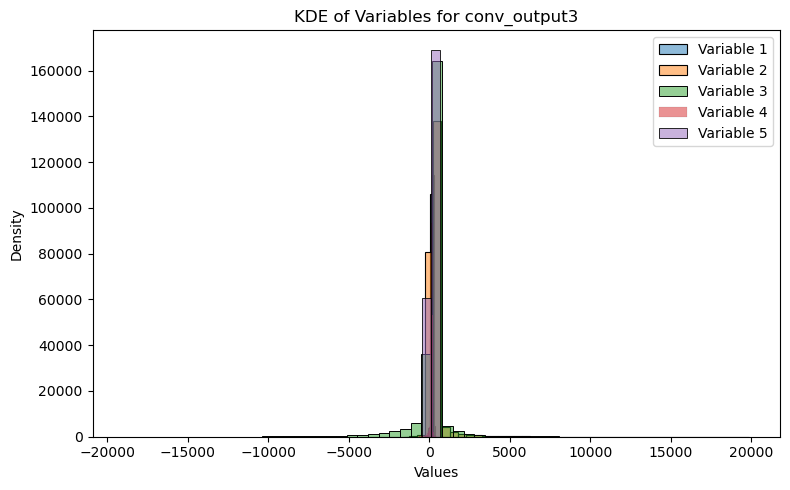

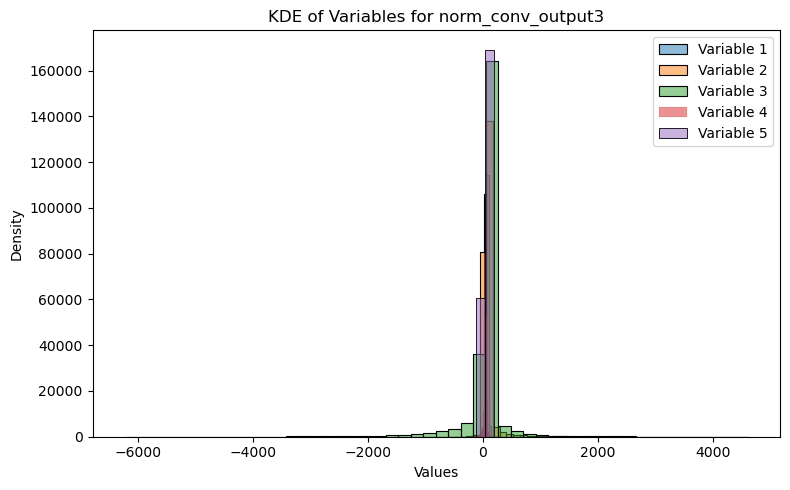

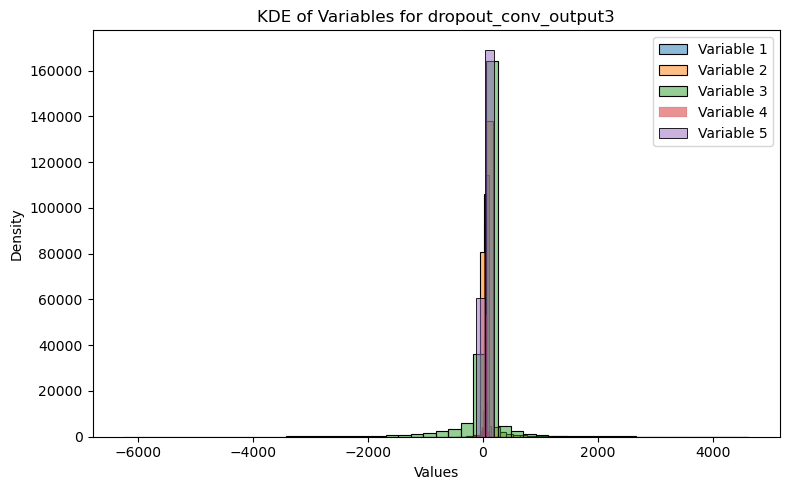

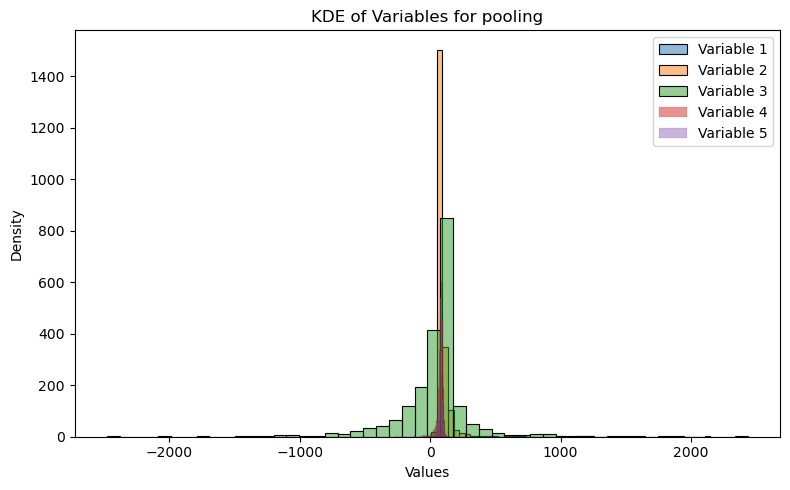

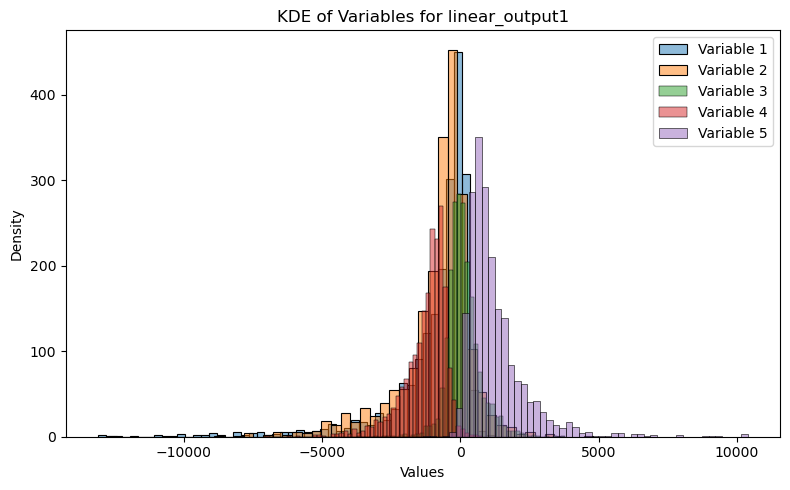

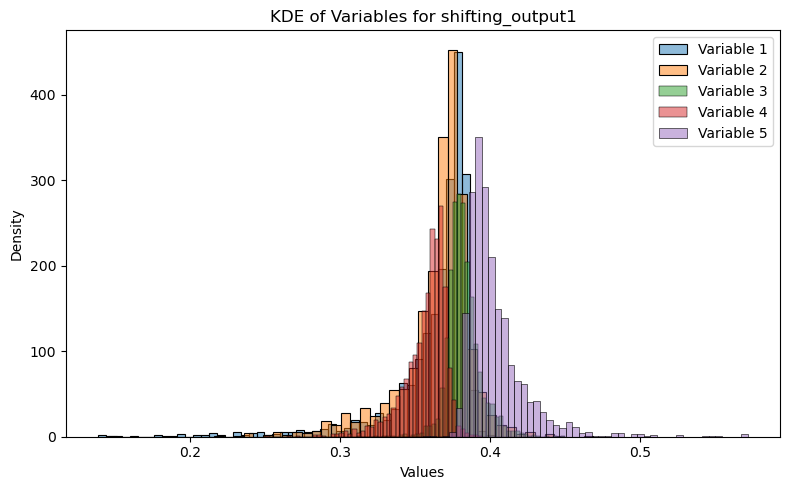

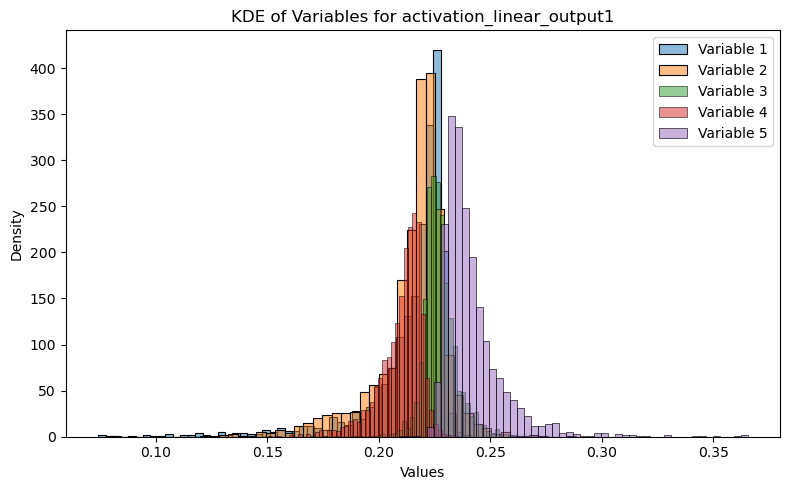

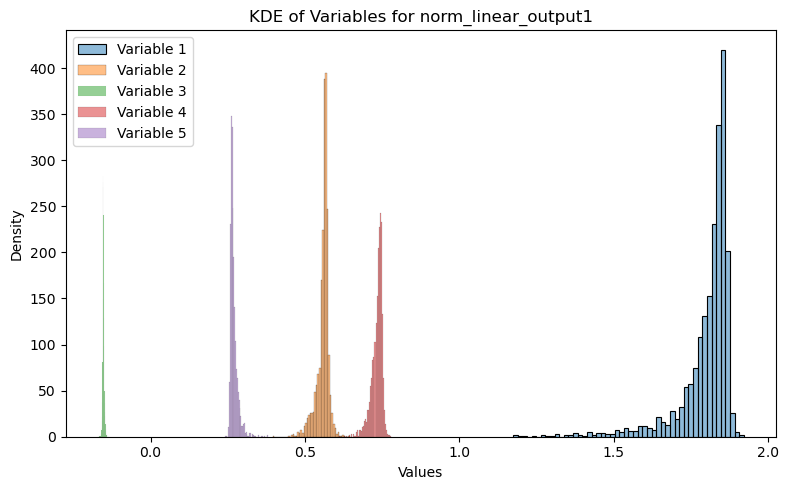

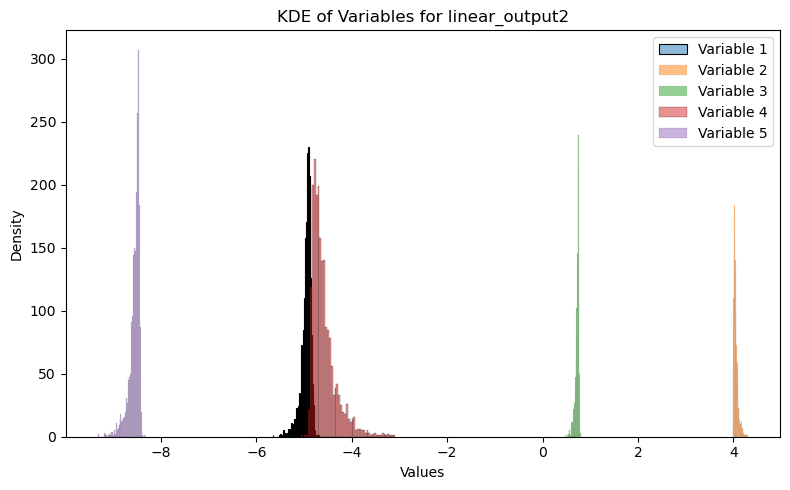

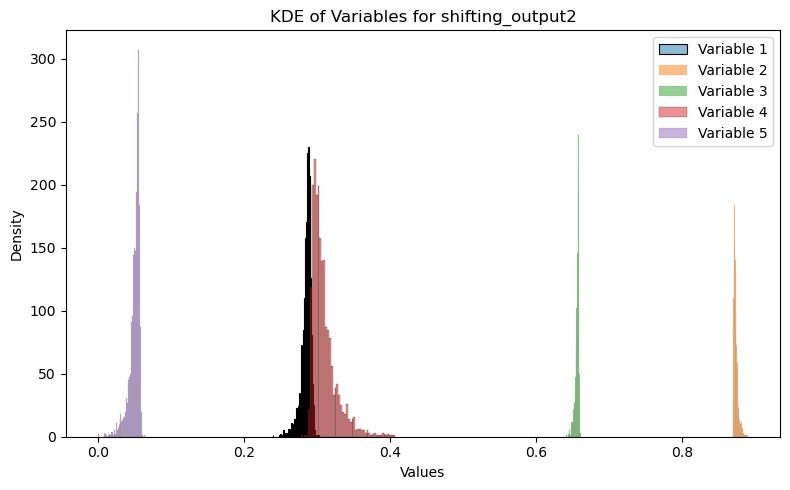

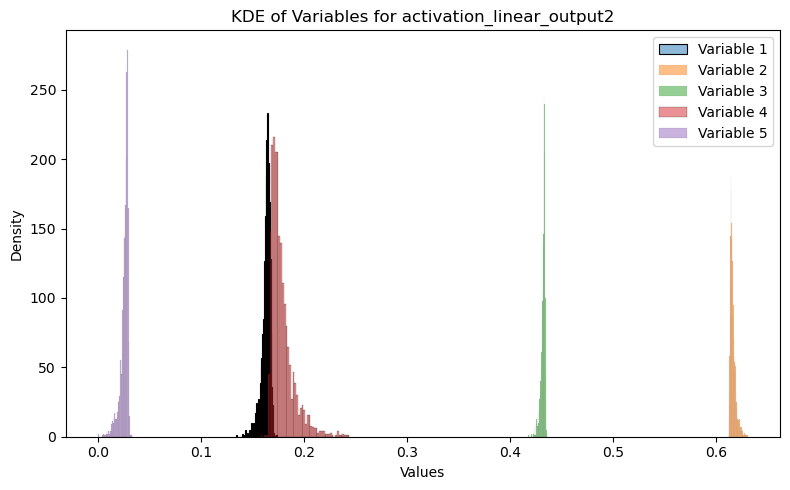

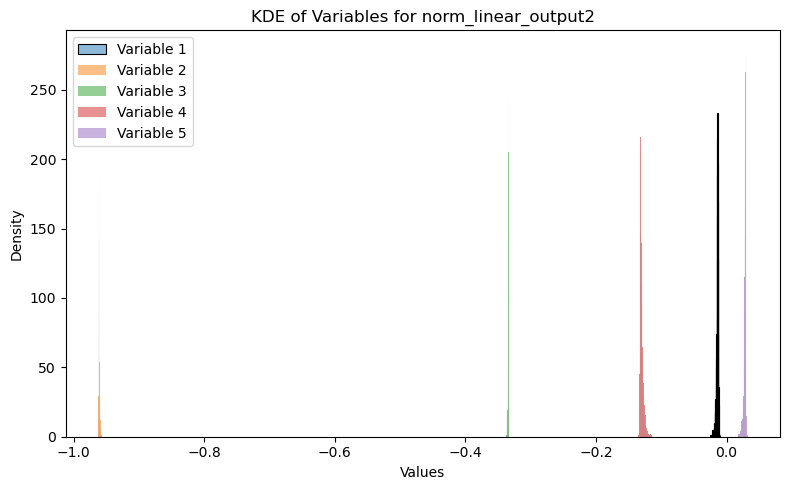

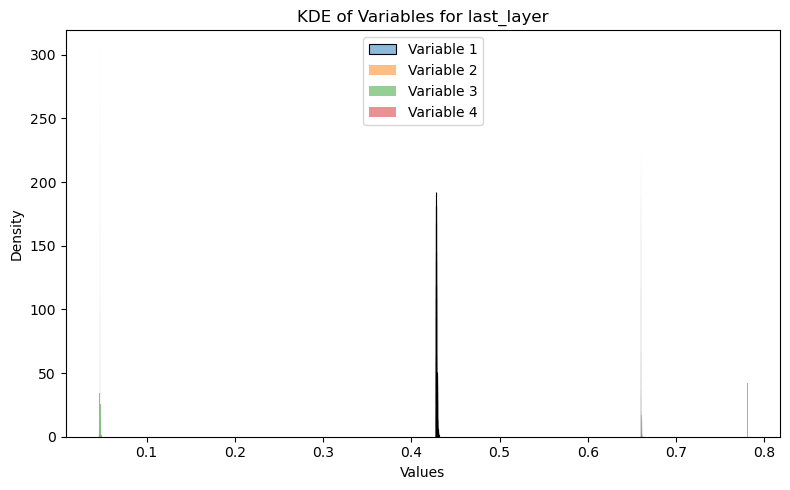

In [5]:
max_vars = 5
# Plot KDE for each key separately
for key, value in intermediate_values_trained.items():
    num_vars = min(value.size(1), max_vars)
    
    plt.figure(figsize=(8, 5))  # Adjust figure size if needed
    
    # Plot KDE for each variable of the current key
    for i in range(num_vars):
        variable_data = value[:, i].cpu().numpy()
        sns.histplot(variable_data, bins=50, kde=False, label=f'Variable {i+1}', alpha=0.5)
    
    plt.title(f'KDE of Variables for {key}')
    plt.xlabel('Values')
    plt.ylabel('Density')
    plt.legend()
    plt.tight_layout()
    plt.show()

## Individual

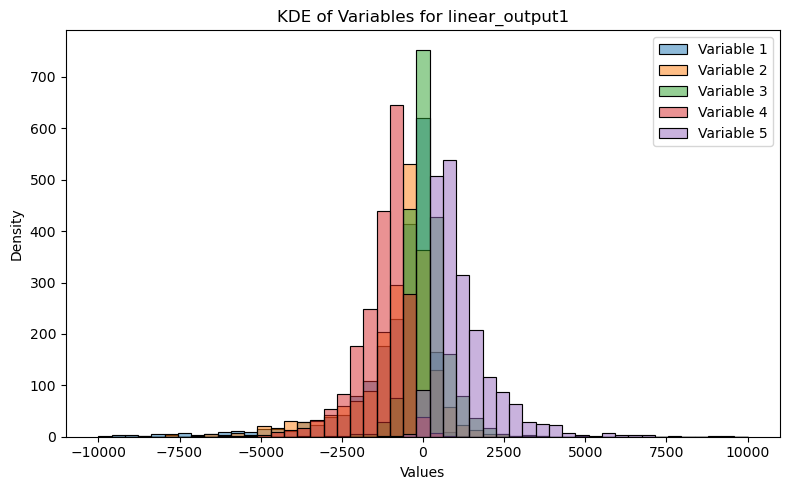

In [4]:
max_vars = 5
bin_edges = np.linspace(-10000, 10000, 50)
key = 'linear_output1'
value = intermediate_values_trained[key]

num_vars = min(value.size(1), max_vars)

plt.figure(figsize=(8, 5))  # Adjust figure size if needed

# Plot KDE for each variable of the current key
for i in range(num_vars):
    variable_data = value[:, i].cpu().numpy()
    sns.histplot(variable_data, bins=bin_edges, kde=False, label=f'Variable {i+1}', alpha=0.5)

plt.title(f'KDE of Variables for {key}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

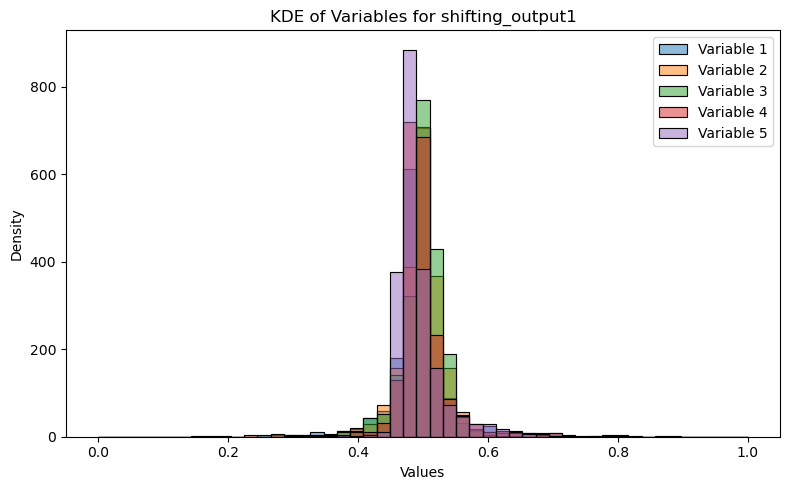

In [46]:
max_vars = 5
bin_edges = np.linspace(0, 1, 50)
key = 'shifting_output1'
value = intermediate_values_untrained[key]

num_vars = min(value.size(1), max_vars)

plt.figure(figsize=(8, 5))  # Adjust figure size if needed

# Plot KDE for each variable of the current key
for i in range(num_vars):
    variable_data = value[:, i].cpu().numpy()
    sns.histplot(variable_data, bins=bin_edges, kde=False, label=f'Variable {i+1}', alpha=0.5)

plt.title(f'KDE of Variables for {key}')
plt.xlabel('Values')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

# Find resolution

In [2]:
# predictions_data = np.load('/sps/t2k/cehrhardt/analysis_tools/distributions/2024-07-29_13-51/prediction.npz', allow_pickle=True)
predictions_data = np.load('/sps/t2k/cehrhardt/analysis_tools/distributions/2024-07-29_11-00/prediction.npz', allow_pickle=True)

predictions = predictions_data['trained']
# features = predictions_data['ini_x']

batch_size = 5000

# predictions_batched = predictions.reshape(-1, test_batch_size, 4)

graph_folder_path = '/sps/t2k/cehrhardt/dataset/graph_1.5M_hitxyztc_t_xyzt_r30'

In [3]:
# Calculate number of full batches
num_full_batches = predictions.shape[0] // batch_size

# Slice the data to include only full batches
predictions_full_batches = predictions[:num_full_batches * batch_size]

# Reshape to create batches for the full batches
predictions_batched = predictions_full_batches.reshape(num_full_batches, batch_size, predictions.shape[1])

# ## Include the last non-full batch if present
# if predictions.shape[0] % batch_size != 0:
#     last_batch = predictions[num_full_batches * batch_size:]
#     last_batch_padded = np.zeros((batch_size, predictions.shape[1]))
#     last_batch_padded[:last_batch.shape[0], :] = last_batch
#     last_batch_padded = last_batch_padded.reshape(1, batch_size, predictions.shape[1])
#     predictions_batched = np.concatenate((predictions_batched, last_batch_padded), axis=0)

In [4]:
#Load the graph
dataset = DatasetFromProcessed(graph_folder_path = graph_folder_path, graph_file_names = ['data.pt'],  verbose = 1)


index_list = np.load('/sps/t2k/cehrhardt/Caverns/index_lists/UnifVtx_electron_HK_10MeV_train_val_test_1.5M.npz')
sampled_data = dataset[index_list['train_idxs']]
true_loader = DataLoader(sampled_data, batch_size=5000, shuffle=False)

In [5]:
norm_pos_all=np.array([])
norm_time_all=np.array([])
norm_time_abs_all=np.array([])
norm_pos_p_all=np.array([])
norm_pos_o_all=np.array([])

for true_data, predict_data in zip(true_loader, predictions_batched):

    true = np.array([true_data.y])
    
    # Check if the size matches the batch size before reshaping
    if true.size == batch_size * 4:
        true = true.reshape(batch_size, 4)
    else:
        break

    predict = predict_data# * (np.array(label_max) - np.array(label_min)) + np.array(label_min) #eps=1e-12 neglected
    
    predict_vtx = predict[:,:3]
    true_vtx = true[:,:3]
    
    norm_pos = predict_vtx - true_vtx
    norm_pos = np.linalg.norm(norm_pos, ord=2, axis=1)  # Compute sqrt(x^2 + y^2 + z^2) for each event

    norm_time = predict[:,3] - true[:,3]
    norm_time_abs = np.abs(norm_time)  # Compute absolute value

    norm_pos_all=np.append(norm_pos_all, norm_pos)
    norm_time_all=np.append(norm_time_all, norm_time)
    norm_time_abs_all=np.append(norm_time_abs_all, norm_time_abs)

res_time = np.quantile(norm_time_abs_all, 0.68, axis=0)
cred_int = np.quantile(norm_time_all, 0.16, axis=0), np.quantile(norm_time_all, 0.84, axis=0)
res_pos = np.quantile(norm_pos_all, 0.68, axis=0)

print(f"Resolution at 68% for:\n- on the position norm: {res_pos:.2f} cm \n- on time: {res_time:.2f} ns\nCredible interval on time at 68%: {cred_int[0]:.2f} ns to {cred_int[1]:.2f} ns")

Resolution at 68% for:
- on the position norm: 119.28 cm 
- on time: 3.51 ns
Credible interval on time at 68%: -3.02 ns to 3.91 ns
